# Bert

Cargando modelos

In [1]:
import torch
from pytorch_transformers import BertTokenizer, BertModel
# OPTIONAL: if you want to have more information on what's happening under the hood, activate the logger as follows
import logging
import numpy as np
logging.basicConfig(level=logging.INFO)

# Load pre-trained model tokenizer (vocabulary)
tokenizer = BertTokenizer.from_pretrained('bert-base-multilingual-cased')


INFO:pytorch_transformers.file_utils:https://s3.amazonaws.com/models.huggingface.co/bert/bert-base-multilingual-cased-vocab.txt not found in cache or force_download set to True, downloading to /tmp/tmpkzjtaz10
100%|██████████| 995526/995526 [00:01<00:00, 951078.44B/s]
INFO:pytorch_transformers.file_utils:copying /tmp/tmpkzjtaz10 to cache at /home/ivanvladimir/.cache/torch/pytorch_transformers/96435fa287fbf7e469185f1062386e05a075cadbf6838b74da22bf64b080bc32.99bcd55fc66f4f3360bc49ba472b940b8dcf223ea6a345deb969d607ca900729
INFO:pytorch_transformers.file_utils:creating metadata file for /home/ivanvladimir/.cache/torch/pytorch_transformers/96435fa287fbf7e469185f1062386e05a075cadbf6838b74da22bf64b080bc32.99bcd55fc66f4f3360bc49ba472b940b8dcf223ea6a345deb969d607ca900729
INFO:pytorch_transformers.file_utils:removing temp file /tmp/tmpkzjtaz10
INFO:pytorch_transformers.tokenization_utils:loading file https://s3.amazonaws.com/models.huggingface.co/bert/bert-base-multilingual-cased-vocab.txt from 

In [5]:
# Tokenize input
text = "[CLS] La UNAM abrió una nueva carrera de Ciencia de Datos tendrá 20.0 alumnos en I.I.M.A.S. en Nuevo León #cienciadedatos [SEP]"
tokenized_text = tokenizer.tokenize(text)
print(tokenized_text)


# Convert token to vocabulary indices
indexed_tokens = tokenizer.convert_tokens_to_ids(tokenized_text)
# Define sentence A and B indices associated to 1st and 2nd sentences (see paper)
segments_ids = [0 for _ in range(len(tokenized_text))]

# Convert inputs to PyTorch tensors
tokens_tensor = torch.tensor([indexed_tokens])
segments_tensors = torch.tensor([segments_ids])

['[CLS]', 'La', 'UNAM', 'abrió', 'una', 'nueva', 'carrera', 'de', 'Ciencia', 'de', 'Datos', 'tend', '##rá', '20', '.', '0', 'alumnos', 'en', 'I', '.', 'I', '.', 'M', '.', 'A', '.', 'S', '.', 'en', 'Nuevo', 'León', '#', 'ciencia', '##ded', '##atos', '[SEP]']


In [7]:
# Set the model in evaluation mode to desactivate the DropOut modules
# This is IMPORTANT to have reproductible results during evaluation!
model = BertModel.from_pretrained('bert-base-multilingual-cased')
model.eval()

# Predict hidden states features for each layer
with torch.no_grad():
    # See the models docstrings for the detail of the inputs
    outputs = model(tokens_tensor, token_type_ids=segments_tensors)
    # PyTorch-Transformers models always output tuples.
    # See the models docstrings for the detail of all the outputs
    # In our case, the first element is the hidden state of the last layer of the Bert model
    encoded_layers = outputs[0]
# We have encoded our input sequence in a FloatTensor of shape (batch size, sequence length, model hidden dimension)
print(encoded_layers.shape)

INFO:pytorch_transformers.modeling_utils:loading configuration file https://s3.amazonaws.com/models.huggingface.co/bert/bert-base-multilingual-cased-config.json from cache at /home/ivanvladimir/.cache/torch/pytorch_transformers/45629519f3117b89d89fd9c740073d8e4c1f0a70f9842476185100a8afe715d1.83b0fa3d7f1ac0e113ad300189a938c6f14d0588a4200f30eef109d0a047c484
INFO:pytorch_transformers.modeling_utils:Model config {
  "attention_probs_dropout_prob": 0.1,
  "directionality": "bidi",
  "finetuning_task": null,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "num_labels": 2,
  "output_attentions": false,
  "output_hidden_states": false,
  "pooler_fc_size": 768,
  "pooler_num_attention_heads": 12,
  "pooler_num_fc_layers": 3,
  "pooler_size_per_head": 128,
  "pooler_type": "first_token_transfor

torch.Size([1, 36, 768])


(36, 768)
Tamaño de matrix X reducida: (36, 2)


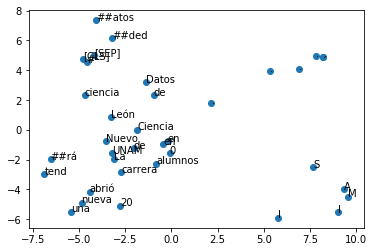

In [10]:
X=encoded_layers.numpy()
X=X.squeeze()
print(X.shape)

import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
pca=PCA(n_components=2)
reduced_X = pca.fit_transform(X)
print("Tamaño de matrix X reducida:", reduced_X.shape)

fig, ax = plt.subplots()
ax.scatter(reduced_X[:,0],reduced_X[:,1])

for i, txt in enumerate(tokenized_text):
    ax.annotate(txt, (reduced_X[i,0], reduced_X[i,1]))

plt.show()


In [12]:
def process_sntc(text):
    tokenized_text = tokenizer.tokenize("[CLS] "+text+" [SEP]")
    
    # Convert token to vocabulary indices
    indexed_tokens = tokenizer.convert_tokens_to_ids(tokenized_text)
    # Define sentence A and B indices associated to 1st and 2nd sentences (see paper)
    segments_ids = [0 for _ in tokenized_text]

    # Convert inputs to PyTorch tensors
    tokens_tensor = torch.tensor([indexed_tokens])
    segments_tensors = torch.tensor([segments_ids])
    
    with torch.no_grad():
    # See the models docstrings for the detail of the inputs
        outputs = model(tokens_tensor, token_type_ids=segments_tensors)
        # PyTorch-Transformers models always output tuples.
        # See the models docstrings for the detail of all the outputs
        # In our case, the first element is the hidden state of the last layer of the Bert model
        encoded_layers = outputs[0]
    X=encoded_layers.numpy()
    X=X.squeeze()
    return tokenized_text,X

def compare_sntc(sntcs,words):
    vecs=[]
    inis=[]
    for sntc,w in zip(sntcs,words):
        t,v=process_sntc(sntc)
        print(t)
        i=t.index(w)
        vecs.append(v[i])
        inis.append(v[0])
    return np.vstack(vecs),np.vstack(inis),words

def draw_sntc(X_words,labels):
    pca=PCA(n_components=2)
    reduced_X = pca.fit_transform(X_words)

    fig, ax = plt.subplots()
    ax.scatter(reduced_X[:,0],reduced_X[:,1])

    for i, txt in enumerate(labels):
        ax.annotate(txt, (reduced_X[i,0], reduced_X[i,1]))

    plt.show()

['[CLS]', 'el', 'hombre', 'alto', '[SEP]']
['[CLS]', 'el', 'rey', 'alto', '[SEP]']
['[CLS]', 'la', 'reina', 'alta', '[SEP]']
['[CLS]', 'la', 'mujer', 'alta', '[SEP]']


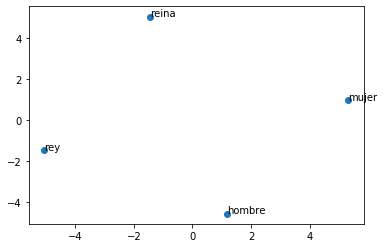

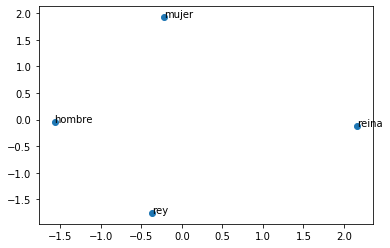

In [13]:
X_words,X_sntc,labels=compare_sntc(["el hombre alto",
                      "el rey alto",
                      "la reina alta",
                      "la mujer alta"],
                     ["hombre","rey","reina","mujer"])
draw_sntc(X_words,labels)
draw_sntc(X_sntc,labels)

['[CLS]', 'el', 'niño', 'corre', '[SEP]']
['[CLS]', 'la', 'niña', 'corre', '[SEP]']
['[CLS]', 'el', 'be', '##be', 'corre', '[SEP]']
['[CLS]', 'el', 'señor', 'corre', '[SEP]']


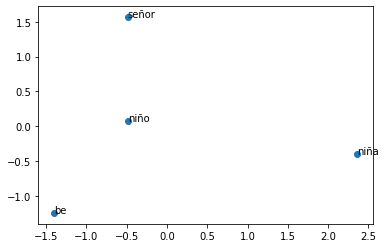

In [14]:
X_words,X_sntc,labels=compare_sntc(["el niño corre",
                      "la niña corre",
                      "el bebe corre",
                      "el señor corre"],
                     ["niño","niña","be","señor"])
draw_sntc(X_words,labels)
draw_sntc(X_sntc,labels)

['[CLS]', 'la', 'ciudad', 'de', 'm', '##é', '##xico', 'es', 'grande', '[SEP]']
['[CLS]', 'pari', '##s', 'es', 'grande', '[SEP]']
['[CLS]', 'm', '##é', '##xico', 'es', 'grande', '[SEP]']
['[CLS]', 'francia', 'es', 'grande', '[SEP]']


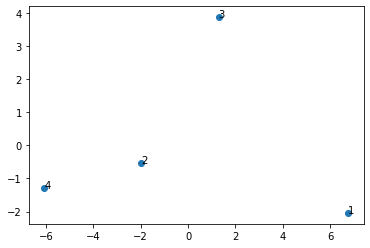

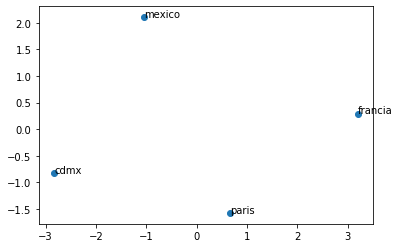

In [15]:
X_words,X_sntc,labels=compare_sntc(["la ciudad de méxico es grande",
                      "paris es grande",
                      "méxico es grande",
                      "francia es grande"],
                     ["es","es","es","es"])
draw_sntc(X_words,['1','2','3','4'])
draw_sntc(X_sntc,['cdmx','paris','mexico','francia'])